In [1]:
import pylidc as pl
from pylidc.utils import consensus
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from utils import get_malignacy_class, filename_from_annotation

In [2]:
from PIL import Image
from gtts import gTTS
from pytesseract import image_to_string
from scipy.io.wavfile import write

from scipy.io import wavfile
from scipy.fft import fft
from scipy.signal import spectrogram

import pandas as pd
from collections import Counter
import bisect

import librosa
import librosa.display

import soundfile as sf
import io


In [3]:
MAX_NODULE_WIDTH = 47
MAX_NODULE_HEIGHT = 47
N_SLICES = 5

In [4]:
def zoomout_nodule(bbox, width, height, n_slices):
    # TODO: what if is outside the picture?
    x_acres = (width - (bbox[0].stop - bbox[0].start))//2
    y_acres = (height - (bbox[1].stop - bbox[1].start))//2

    x_slice = slice(bbox[0].start - x_acres, bbox[0].start - x_acres + width, None)
    y_slice = slice(bbox[1].start - y_acres, bbox[1].start - y_acres + width, None)

    z_slice = np.linspace(bbox[2].start, bbox[2].stop, n_slices, endpoint=False, dtype=int)

    return (x_slice, y_slice, z_slice)

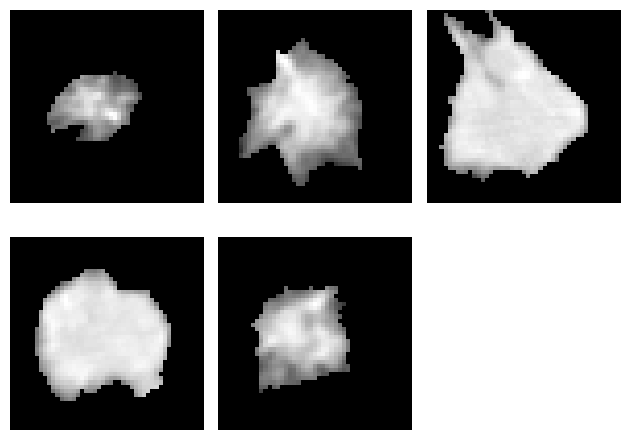

In [5]:
def get_cropped_annot(scan: pl.Scan, mask: bool=False):
    vol = scan.to_volume(verbose=False)

    images = []
    masks = []

    nods = scan.cluster_annotations()
    for anns in nods:
        cmask, cbbox, _ = consensus(anns, clevel=0.5,
                                pad=[(10,10), (10,10), (0,0)])

        full_mask = np.full_like(vol, False, dtype=bool)
        full_mask[cbbox] = cmask

        cbbox = zoomout_nodule(cbbox, MAX_NODULE_WIDTH, MAX_NODULE_HEIGHT, N_SLICES)
        cropped = vol[cbbox]
        cropped_mask = ~full_mask[cbbox]
        if mask:
            cropped[cropped_mask] = -1000 # TODO: maybe pick different value

        # Scale values
        # TODO: maybe pick different values
        cropped += 1000
        cropped = cropped / 2000

        images.append(cropped)
        masks.append(cropped_mask)

    return images, masks


scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0001').first()
cropped, _ = get_cropped_annot(scan, True)

# Set up the plot.
for i in range(N_SLICES):
    plt.subplot(2, 3, i+1)
    plt.imshow(cropped[0][:, :, i], cmap=plt.cm.gray)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
malign_path = Path("data/images/malign")
belign_path = Path("data/images/belign")

os.makedirs(malign_path, exist_ok=True)
os.makedirs(belign_path, exist_ok=True)

scans = pl.query(pl.Scan).all()
for scan in scans:
    try:
        cropped, masks = get_cropped_annot(scan, True)

        nods = scan.cluster_annotations()
        for i, anns in enumerate(nods):
            label = get_malignacy_class(anns)
            if label == 0:
                continue
            
            filename = filename_from_annotation(anns[0])
            mask_filename = filename + "-mask"
            if label == 1:
                np.save(malign_path/filename, cropped[i])
                np.save(malign_path/mask_filename, masks[i])
            elif label == -1:
                np.save(belign_path/filename, cropped[i])
                np.save(belign_path/mask_filename, masks[i])

    except RuntimeError as e:
        print(e)

Couldn't find DICOM files for Scan(id=1,patient_id=LIDC-IDRI-0078) in C:/Users/Daniela/Desktop/Fac/3ºano/Lab_IACD/Project1/manifest-1727162347556/LIDC-IDRI\LIDC-IDRI-0078
Couldn't find DICOM files for Scan(id=2,patient_id=LIDC-IDRI-0069) in C:/Users/Daniela/Desktop/Fac/3ºano/Lab_IACD/Project1/manifest-1727162347556/LIDC-IDRI\LIDC-IDRI-0069
Couldn't find DICOM files for Scan(id=3,patient_id=LIDC-IDRI-0079) in C:/Users/Daniela/Desktop/Fac/3ºano/Lab_IACD/Project1/manifest-1727162347556/LIDC-IDRI\LIDC-IDRI-0079
Couldn't find DICOM files for Scan(id=4,patient_id=LIDC-IDRI-0101) in C:/Users/Daniela/Desktop/Fac/3ºano/Lab_IACD/Project1/manifest-1727162347556/LIDC-IDRI\LIDC-IDRI-0101
Couldn't find DICOM files for Scan(id=5,patient_id=LIDC-IDRI-0110) in C:/Users/Daniela/Desktop/Fac/3ºano/Lab_IACD/Project1/manifest-1727162347556/LIDC-IDRI\LIDC-IDRI-0110
Couldn't find DICOM files for Scan(id=6,patient_id=LIDC-IDRI-0115) in C:/Users/Daniela/Desktop/Fac/3ºano/Lab_IACD/Project1/manifest-1727162347556

KeyboardInterrupt: 

max-min = 0.36
% mais recorrente = 1.4
27.01 72.99
0.5505
most common zone -> 0.55


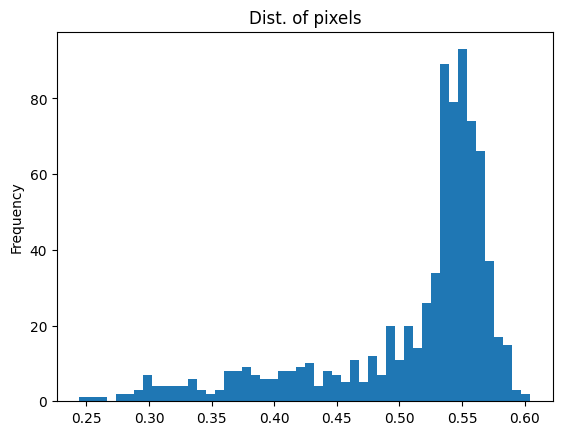

_________________
0.5505


' \nintencidade                                               -> ver diff entre max e min\nfrequência                                                -> ver % do mais recorrente\nespectograma(variação das frequências)                    -> ver % de casos (entre 0.5 e 0.6) ou (aparência sup a 4%) \ntempo do audio                                            -> diff entre a maior frequência e a menor (max-min)\nfrequência fundamental                                    -> o mais frequênte abaixo de 0.5\ntaxa de cruzamento por zero                               ->\nenergia                                                   ->\n'

In [42]:
#import base64 

image_data = cropped[0][:,:,3] 

x1, y1 = image_data.shape

x = x1//2
y = y1//2

'''
#print(x, y)
#print(image_data[x][y]) #image is array
#print(image_data.max()) #pixel com mais intencidade
#print(image_data.min()) #pixel com menor intencidade

pd.Series(image_data.flatten()).plot(kind='hist',
                                       bins = 50,
                                       title='Dist. of pixels')
plt.show()

list = []
for i in range(x1):
    for j in range(y1):
        if image_data[i][j]!=0:
            list.append(image_data[i][j])


'''


def find_first_greater(list, x, comp):
    # Use bisect_right to find the index where x would go to maintain sorted order
    index = bisect.bisect_right(list, x)
    
    # Check if the index is within the bounds of the list
    if index < comp: #len(list)
        return index  # This is the first instance where the number is greater than x
    else:
        return comp+1  # If no element is greater than x

def racist(img):
    x1, y1 = img.shape
    x = x1//2
    y = y1//2
    list = []
    #print(f"comp = {len(list)}")
    for i in range(x1):
        for j in range(y1):
            if image_data[i][j]!=0:
                list.append(float(image_data[i][j]))
    comp = len(list)

    #print(f"comp = {comp}")
    list = sorted(list)#, key=float

    #ver max diff
    print(f"max-min = {round(list[comp-1] - list[0],4)}")

    ''' 
    tentar div list em 50 diff catg
    '''

    counter = Counter(list)

    #ver % do mais recorrente
    print(f"% mais recorrente = {round(counter.most_common(1)[0][1]*100/comp,2)}")
     
    cinf = round((find_first_greater(list, 0.5, comp)-1)*100/comp,2)
    csup = round(100-cinf,2)
    print(cinf, csup)

    #most common zone
    mcommon = round(bindario(list),2)
    print(f"most common zone -> {mcommon}")

    return list


list = racist(image_data)
#print(list)

#for pixel-if != 0 -> traduzir para frequência


#print(type(list), type(image_data), type(image_data[0][0]), type(float(image_data[0][0])), type(list[0]))

pd.Series(list).plot(kind='hist',
                                       bins = 50,
                                       title='Dist. of pixels')
plt.show()


print('_________________')


# Your list of numbers (replace this with your actual data)
#numbers = [...]  # Replace this with your list

# Define the number of bins (50 bins)


def bindario(list):
    num_bins = 50

    bin_edges = np.linspace(min(list), max(list), num_bins + 1)

    binned_indices = np.digitize(list, bin_edges) - 1  #  Subtract 1 to make bins zero-based
    binned_indices = binned_indices[:-1]

    bins = [0 for _ in range(num_bins)]
    for num, bin_idx in zip(list, binned_indices):
        bins[bin_idx]+=1

    #print(type(bin_edges))
    #print(bin_edges)

    #find pos of max
    #print((bin_edges[bins.index(max(bins))] + bin_edges[bins.index(max(bins))+1])/2)

    return(bin_edges[bins.index(max(bins))] + bin_edges[bins.index(max(bins)) + 1])/2




#image_data = image_data.copy(order='C')

#converted_string = base64.b64encode(image_data) 
#print(converted_string)
 
  
#sound = gTTS(converted_string, lang="en")
#sound.save("sound.mp3")

''' 
intencidade                                               -> ver diff entre max e min
frequência                                                -> ver % do mais recorrente
espectograma(variação das frequências)                    -> ver % de casos (entre 0.5 e 0.6) ou (aparência sup a 4%) 
tempo do audio                                            -> diff entre a maior frequência e a menor (max-min)
frequência fundamental                                    -> o mais frequênte abaixo de 0.5
taxa de cruzamento por zero                               ->
energia                                                   ->
'''


In [10]:
''' 
por imagem
converter em som
'''
image_data = cropped[0][:,:,2]  


def convert_to_sound(image_data):
    
    min_freq = 20      # Minimum frequency (Hz)
    max_freq = 20000   # Maximum frequency (Hz)

    # Generate a sine wave for each pixel
    sample_rate = 44100  # Standard sampling rate for audio (Hz)
    duration = 0.01      # Duration of each pixel's sound (seconds)

    img = Image.fromarray(image_data).convert('L')
    img_data = np.array(img)

    # Normalize the pixel intensities to the frequency range
    frequencies = np.interp(img_data, [0, 255], [min_freq, max_freq])    

    audio_data = np.hstack([generate_sine_wave(freq, duration, sample_rate) for freq in frequencies.flatten()])

    audio_data = np.int16(audio_data / np.max(np.abs(audio_data)) * 32767)

    pass

# Convert NumPy array to a Pillow Image
img = Image.fromarray(image_data).convert('L')

img_data = np.array(img)

# Normalize pixel values to a frequency range (e.g., 20 Hz to 20,000 Hz)
min_freq = 20      # Minimum frequency (Hz)
max_freq = 20000   # Maximum frequency (Hz)

# Normalize the pixel intensities to the frequency range
frequencies = np.interp(img_data, [0, 255], [min_freq, max_freq])

# Generate a sine wave for each pixel
sample_rate = 44100  # Standard sampling rate for audio (Hz)
duration = 0.01      # Duration of each pixel's sound (seconds)

def generate_sine_wave(frequency, duration, sample_rate):
    t = np.linspace(0, duration, int(sample_rate * duration), False)
    wave = 0.5 * np.sin(2 * np.pi * frequency * t)
    return wave

# Create an audio array by stacking sine waves
audio_data = np.hstack([generate_sine_wave(freq, duration, sample_rate) for freq in frequencies.flatten()])

# Normalize the audio data
audio_data = np.int16(audio_data / np.max(np.abs(audio_data)) * 32767)

# Save the result as a WAV file
#write("image_to_sound.wav", sample_rate, audio_data)


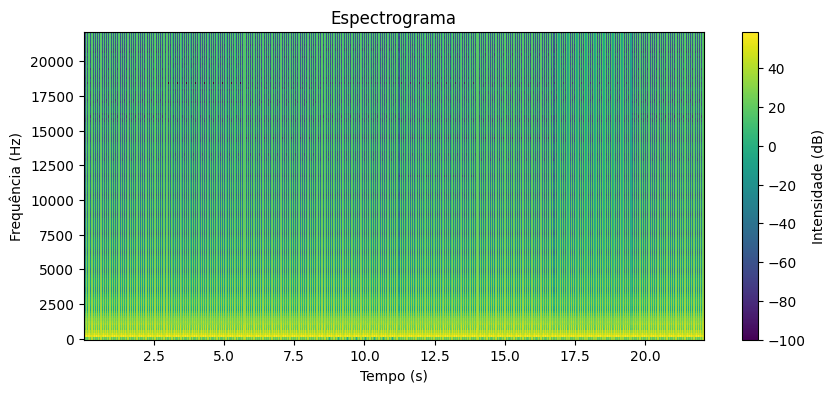

In [14]:
''' 
intencidade
frequência 
espectograma(variação das frequências)
tempo do audio
frequência fundamental
taxa de cruzamento por zero
energia
'''


#criar lista com as infos [duration, frequência fundamental, taxa de cruzamento por zero, energia]

duration = len(audio_data) / sample_rate


# Análise 3: Espectrograma (Domínio da Frequência ao Longo do Tempo)
frequencies, times, Sxx = spectrogram(audio_data, sample_rate)
plt.figure(figsize=(10, 4))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx))
plt.ylabel('Frequência (Hz)')
plt.xlabel('Tempo (s)')
plt.title('Espectrograma')
plt.colorbar(label='Intensidade (dB)')
plt.show()

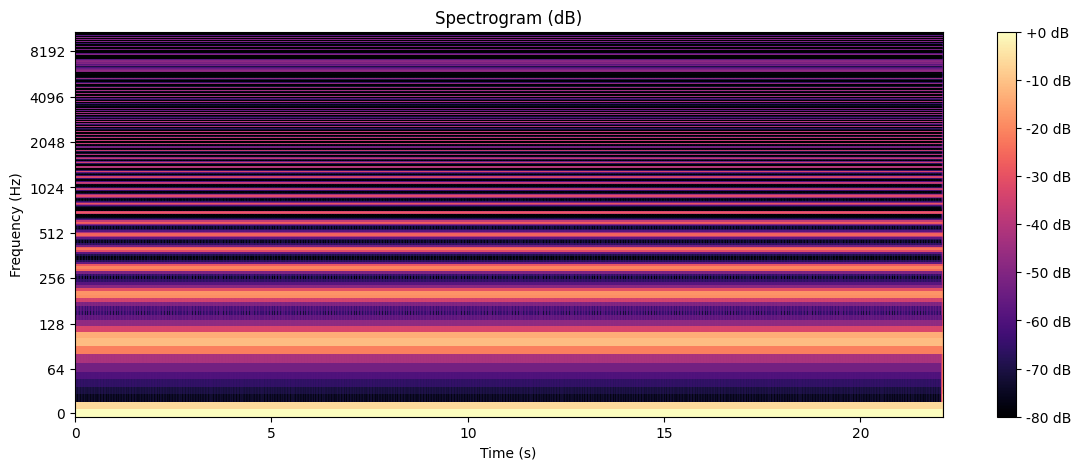

<Figure size 640x480 with 0 Axes>

In [14]:
import librosa
import librosa.display

# Load the audio file (replace 'your_audio_file.wav' with your file)
audio_file = 'image_to_sound.wav'
y, sr = librosa.load(audio_file)


# 2. Plot the Spectrogram (Short-time Fourier transform)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
plt.figure(figsize=(14, 5))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (dB)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()


# Save the spectrogram as an image (PNG, JPG, etc.)
plt.savefig('spectrogram_image2.png', bbox_inches='tight', pad_inches=0.1, dpi=300)



<class 'numpy.ndarray'>


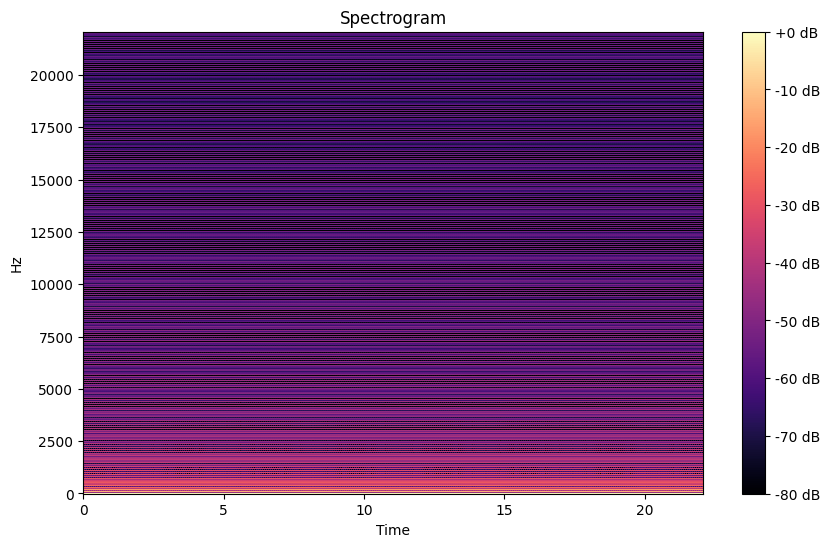

<Figure size 640x480 with 0 Axes>

In [13]:
''' 
# Load the audio file (replace 'your_audio_file.wav' with your file)
audio_file = 'image_to_sound.wav'
y, sr = librosa.load(audio_file)

print(type(y), type(sr), type(sample_rate), type(audio_data))
# Write the audio data to this file-like object in WAV format
sf.write(file_like_object, audio_data, sample_rate, format='WAV')
'''

print(type(audio_data))
# Check if the audio data is integer type
if np.issubdtype(audio_data.dtype, np.integer):
    # Normalize the audio data to float32 in the range [-1, 1]
    audio_data = audio_data / np.max(np.abs(audio_data), axis=0)

S = librosa.stft(audio_data)  # Short-time Fourier transform
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)  # Convert to decibel scale

# Plot the spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(S_db, sr=sample_rate, x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()


# Save the spectrogram as an image (PNG, JPG, etc.)
plt.savefig('spectrogram_image.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

# Optionally display the image
# plt.show()

